In [56]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, fbeta_score
from sklearn.datasets import make_classification

# Generate an imbalanced dataset
n_samples = 10000
n_features = 10
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=5,
                           n_redundant=0,
                           n_clusters_per_class=4,
                           class_sep=0.8,
                           weights=[0.9, 0.1],
                           flip_y=0,
                           random_state=42)

print(f"Dataset shape: {X.shape}, {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

# Split the data into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)


def initial_balance(X, y):
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]
    n_pos = len(pos_indices)

    sampled_neg_indices = np.random.choice(neg_indices, size=n_pos,
                                           replace=False)
    balanced_indices = np.concatenate([pos_indices, sampled_neg_indices])
    return X[balanced_indices], y[balanced_indices]


# Balance only the training data
X_train_balanced, y_train_balanced = initial_balance(X_train, y_train)

print(
    f"Balanced training set shape: {X_train_balanced.shape}, {y_train_balanced.shape}")
print(
    f"Balanced training set class distribution: {np.bincount(y_train_balanced)}")

# Train pilot model on balanced training data
pilot_model = LogisticRegression()
pilot_model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities only for the training set
train_probs = pilot_model.predict_proba(X_train)[:, 1]


def optimized_sampling(X, y, probs, desired_rate=0.3):
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    w = np.mean(probs[neg_indices])
    sampling_probs = desired_rate * probs[neg_indices] / w

    u = np.random.rand(len(neg_indices))
    selected_neg_indices = neg_indices[u < sampling_probs]

    optimized_indices = np.concatenate([pos_indices, selected_neg_indices])
    return X[optimized_indices], y[optimized_indices]


# Apply optimized sampling only to the training set
X_train_optimized, y_train_optimized = optimized_sampling(X_train, y_train,
                                                          train_probs)

print(
    f"Optimized training set shape: {X_train_optimized.shape}, {y_train_optimized.shape}")
print(
    f"Optimized training set class distribution: {np.bincount(y_train_optimized)}")
print("\n" + "-" * 55)
# Train final model on optimized training data
# final_model = LogisticRegression()
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train_optimized, y_train_optimized)


def adjust_predictions(probs, sampling_rate=0.4):
    odds = probs / (1 - probs)
    adjusted_odds = odds / sampling_rate
    return adjusted_odds / (1 + adjusted_odds)


# Predict and adjust probabilities for test set
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
adjusted_proba = adjust_predictions(y_pred_proba)
y_pred = (adjusted_proba > 0.5).astype(int)

f_beta_value = 3

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of the optimized model: {accuracy:.4f}")
print(
    f"\nF-beta score (Optimized), beta={f_beta_value}: {fbeta_score(y_test, y_pred, beta=f_beta_value): .4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compare with a model trained on the original imbalanced training data
# imbalanced_model = LogisticRegression()
imbalanced_model = RandomForestClassifier(n_estimators=100, random_state=42)
imbalanced_model.fit(X_train, y_train)
y_pred_imb = imbalanced_model.predict(X_test)
imbalanced_accuracy = accuracy_score(y_test, y_pred_imb)
# create a separator using "-" to separate the two models
print("\n" + "-" * 55)
print(
    f"\nAccuracy of the model trained on imbalanced data: {imbalanced_accuracy:.4f}")
print(
    f"\nF-beta score (Imbalanced): beta = {f_beta_value}: {fbeta_score(y_test, y_pred_imb, beta=f_beta_value): .4f}")
print("\nClassification Report (Imbalanced):")
print(classification_report(y_test, y_pred_imb))
print("\n" + "-" * 55)


Dataset shape: (10000, 10), (10000,)
Class distribution: [9000 1000]
Balanced training set shape: (1580, 10), (1580,)
Balanced training set class distribution: [790 790]
Optimized training set shape: (3011, 10), (3011,)
Optimized training set class distribution: [2221  790]

-------------------------------------------------------

Accuracy of the optimized model: 0.8365

F-beta score (Optimized), beta=3:  0.7352

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      1790
           1       0.37      0.82      0.51       210

    accuracy                           0.84      2000
   macro avg       0.67      0.83      0.71      2000
weighted avg       0.91      0.84      0.86      2000

-------------------------------------------------------

Accuracy of the model trained on imbalanced data: 0.9220

F-beta score (Imbalanced): beta = 3:  0.3163

Classification Report (Imbalanced):
              precision    recall  f

Matplotlib is building the font cache; this may take a moment.


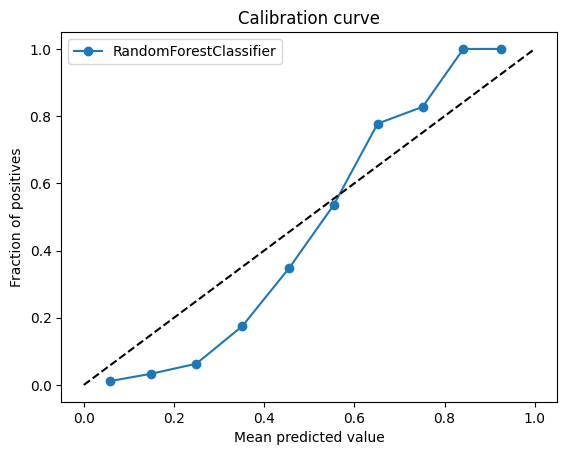

In [57]:
# get calibration curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_pos = final_model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test,
                                                                prob_pos,
                                                                n_bins=10)

plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, marker='o',
         label='RandomForestClassifier')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()

plt.show()


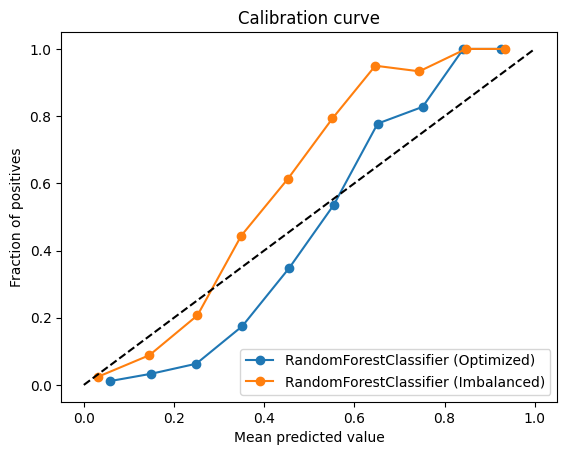

In [75]:
# get calibration curve for imbalanced model alongside the optimized model
prob_pos_imb = imbalanced_model.predict_proba(X_test)[:, 1]
fraction_of_positives_imb, mean_predicted_value_imb = calibration_curve(y_test,
                                                                        prob_pos_imb,
                                                                        n_bins=10)

plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, marker='o',
         label='RandomForestClassifier (Optimized)')
plt.plot(mean_predicted_value_imb, fraction_of_positives_imb, marker='o',
         label='RandomForestClassifier (Imbalanced)')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()

plt.show()

